In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
from rasterio.plot import show, reshape_as_raster
from rasterio.transform import from_bounds
from shapely.geometry import box
from stand_mapping.data import fetch
%matplotlib inline

# Read in some vector data
This layer shows the forest stands at the University of Washington's Charles L. Pack Experimental Forest.

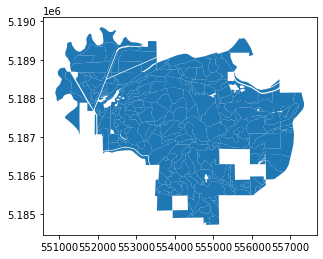

In [2]:
PACK_SHP = '../data/raw/stand_boundaries/packforest_2015_stands.shp'
pack_stands = gpd.read_file(PACK_SHP)
pack_stands.plot();

Define our Area of Interest with a Bounding Box

In [3]:
XMIN, YMIN = 553000, 5187000
WIDTH, HEIGHT = 1500, 1500
XMAX, YMAX = XMIN + WIDTH, YMIN + HEIGHT
BBOX = XMIN, YMIN, XMAX, YMAX
BBOX

(553000, 5187000, 554500, 5188500)

In [4]:
EPSG = pack_stands.crs.to_epsg()
EPSG

26910

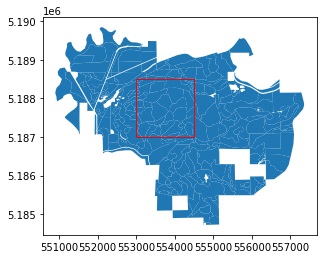

In [5]:
fig, ax = plt.subplots()
pack_stands.plot(ax=ax)
gpd.GeoDataFrame(geometry=[box(*BBOX)], 
                 crs=EPSG).plot(ax=ax, facecolor='none', edgecolor='red');

Fetch NAIP Aerial Imagery from The National Map REST Service

In [6]:
naip = fetch.naip_from_tnm(bbox=BBOX, res=1, inSR=EPSG, format='jpgpng')
naip.shape

(1500, 1500, 3)

# Quick View of the Aerial Imagery
Note that extent uses local image coordinates. There is no awareness of geospatial coordinates yet.

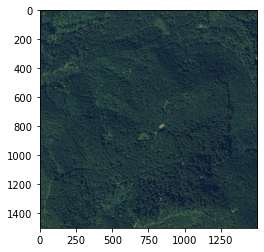

In [7]:
plt.imshow(naip);

# Use Rasterio to Georeference and Plot
We first need to convert the image into the shape that `rasterio` wants. The TNM NAIP REST web service returns the RGB image with shape `(height, width, channels)`. `rasterio`, however, expects a raster format with shape `(bands, height, width`). 

Once we calculate the affine transformation that will project the image into the appropiate geographic extent, we can display the raster in the appropriate geographic extent using `rasterio.plot.show`.



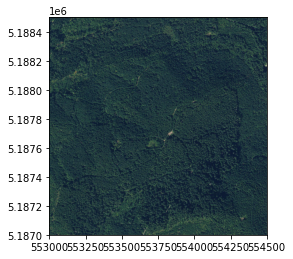

In [8]:
affine_transform = from_bounds(*BBOX, WIDTH, HEIGHT)
# use rasterio.plot.show to pull this all together

raster = reshape_as_raster(naip)
show(raster, transform=affine_transform);

In [9]:
affine_transform

Affine(1.0, 0.0, 553000.0,
       0.0, -1.0, 5188500.0)

In [10]:
raster.shape

(3, 1500, 1500)

# Add Georeferenced Overlays
Now that the extent of our image is related to the geographic coordinates, we can also add vectors to the display.

C:\Users\ddiaz\Miniconda3\envs\stand_mapping\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


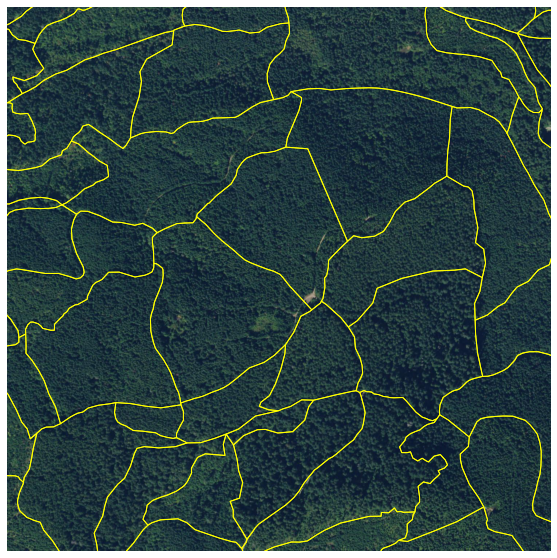

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

show(raster, transform=affine_transform, ax=ax)
clipped_stands = gpd.clip(pack_stands, 
                          # generate a bbox polygon using shapely's box
                          mask=box(*BBOX).buffer(2) # buffer slightly so that edges are off the image
                          )
clipped_stands.plot(ax=ax, facecolor='none', edgecolor='yellow')
ax.axis('off')
plt.show();

# Add some labels to the polygons

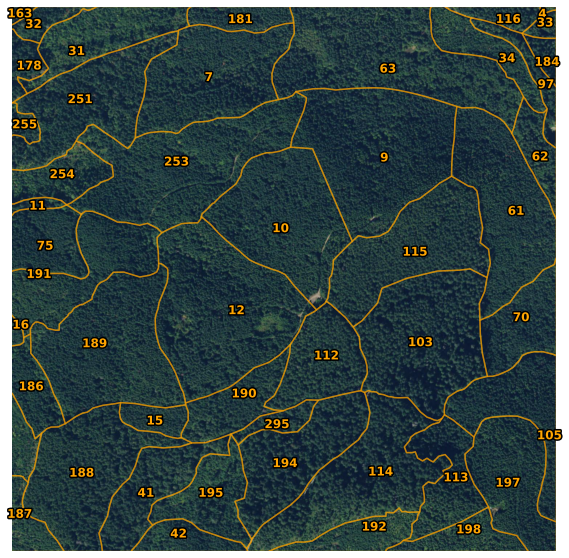

In [12]:
clipped_stands['coords'] = clipped_stands['geometry'].apply(lambda x: x.representative_point().coords[0])

fig, ax = plt.subplots(figsize=(10,10))

show(raster, transform=affine_transform, ax=ax)
clipped_stands.plot(ax=ax, facecolor='none', edgecolor='orange', lw=1.5, alpha=0.5)

for idx, row in clipped_stands.iterrows():
    label_x, label_y = row['coords']
    label = idx
    
    # this block moves labels away from edges
    if abs(label_x - XMIN) < 10:
        horizontalalignment='left'
        label_x += 15
    if abs(label_x - XMAX) < 10:
        horizontalalignment='right'
        label_x -= 15
    else:
        horizontalalignment='center'
    if abs(label_y - YMIN) < 10:
        verticalalignment='top'
        label_y += 15
    elif abs(label_y - YMAX) < 10:
        verticalalignment='bottom'
        label_y -= 15
    else:
        verticalalignment='center'
    
    # add the labels
    ax.annotate(s=label, 
                xy=(label_x,label_y),
                horizontalalignment=horizontalalignment,
                verticalalignment=verticalalignment,
                color='orange', size=12, fontweight='bold',
                path_effects=[pe.withStroke(linewidth=3, foreground='black')])
    
ax.axis('off')
plt.show();